# Running the Circuit Model with its Modulation

In [1]:
import matplotlib.pylab as plt
import numpy as np
import plot_tools as pt

## Fetching the Time-Varying Modulation

In [2]:
from src.Modulation import Events, build_arrays, EpisodeLength, Fraction, Smoothing
#plt.subplots_adjust(bottom=.4, top=.99, hspace=.8)
t, Neuromodulatory, Sensory = build_arrays(Events)

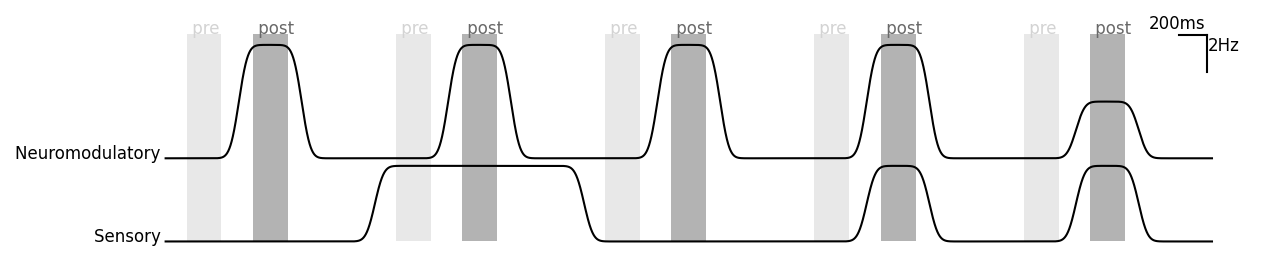

In [3]:
fig, ax = plt.subplots(1, figsize=(10,2))

ax.plot(t, Sensory, 'k-')
ax.annotate('Sensory ', (0,0), ha='right')
ax.plot(t, 1.1*Sensory.max()+Neuromodulatory, 'k-')
ax.annotate('Neuromodulatory ', (0,1.1*Sensory.max()), ha='right')

Width = EpisodeLength*Fraction-4*Smoothing
PREs, POSTs = [], []
Max = 1.1*(Sensory.max()+Neuromodulatory.max())
for e, Event in enumerate(Events):
    t0, tcenter = e*EpisodeLength, (e+.5)*EpisodeLength
    PREs.append([t0+3*Smoothing,t0+3*Smoothing+Width])
    ax.fill_between(PREs[e], [0,0], Max*np.ones(2), color='lightgray', alpha=.5, lw=0)
    ax.annotate(' pre', (PREs[e][0], Max), color='lightgray')
    POSTs.append([tcenter-Width/2.,tcenter+Width/2.])
    ax.fill_between(POSTs[e], [0,0], Max*np.ones(2), color='dimgray', alpha=.5, lw=0)
    ax.annotate(' post', (POSTs[e][0], Max), color='dimgray')
    
pt.draw_bar_scales(ax, loc='top-right',
                   Xbar=200, Xbar_label='200ms', Ybar=2, Ybar_label='2Hz')
pt.set_plot(ax, [], xticks=[])

In [4]:
from src.ntwk_sim import run_ntwk_sim
from src.CoupledCircuit import Model, REC_POPS, COLORS
from neural_network_dynamics import ntwk

AFF_POPS = ['BgExc', 'ExcToVip', 'ExcToThal']

Model['tstop'] = t[-1]+t[1]
NTWK = run_ntwk_sim(Model, REC_POPS,
                    AFF_POPS=AFF_POPS,
                    AFF_RATE_ARRAYS = [Model['F_BgExc']+0*t, 
                                       Neuromodulatory,
                                       Neuromodulatory+Sensory],
                   SEED=1)

ntwk.recording.write_as_hdf5(NTWK, filename='data/model-run.h5')

initializing simulation [...]
running simulation [...]
-> done !


### Visualize the Circuit Dynamics

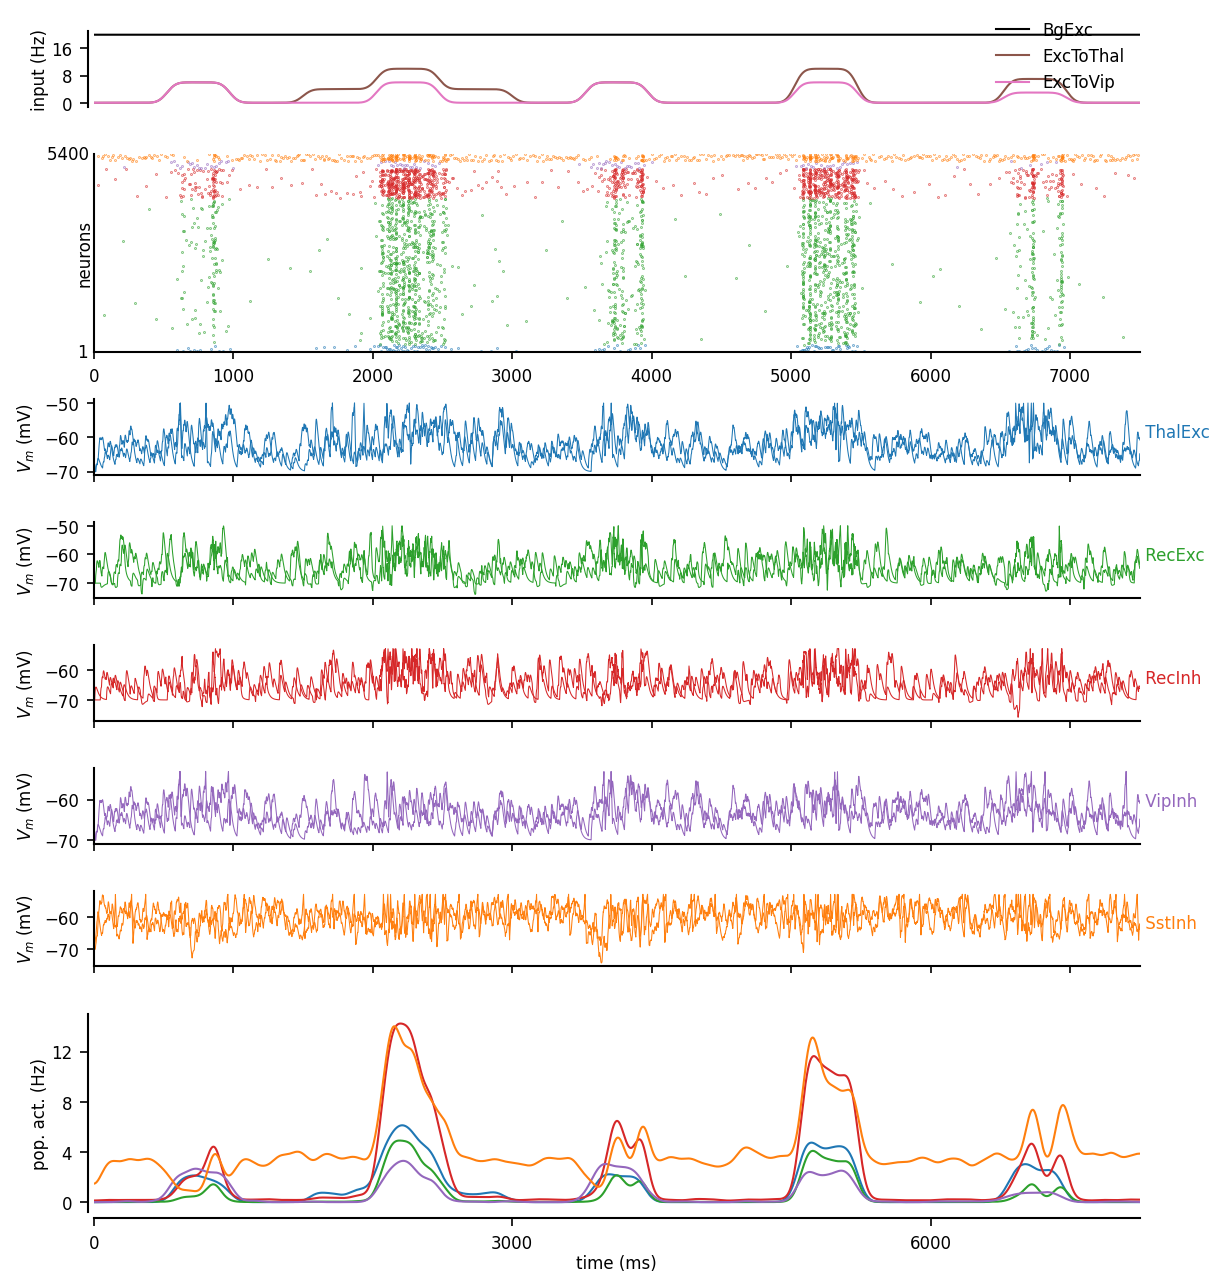

In [5]:
data = ntwk.recording.load_dict_from_hdf5('data/model-run.h5')
fig, _ = ntwk.plots.activity_plots(data, REC_POPS,
                                   COLORS = COLORS,
                                   fig_args=dict(figsize=(1.2,.8)),
                                   pop_act_args=dict(smoothing=50,lw=1),
                                   Vm_args=dict(clip_spikes=True, lw=0.5))

## Analyze

In [6]:
data = ntwk.recording.load_dict_from_hdf5('data/model-run.h5')
from src.CoupledCircuit import Model, REC_POPS, COLORS
RESP = []
for e, event in enumerate(Events):
    RESP.append({})
    for pop in ['RecExc', 'VipInh', 'SstInh']:
        RESP[e][pop] = {}
        for key, T in zip(['pre','post'], [PREs[e], POSTs[e]]):
            cond = (t>T[0]) & (t<T[1])
            RESP[e][pop][key] = np.mean(data['POP_ACT_%s'%pop][cond])

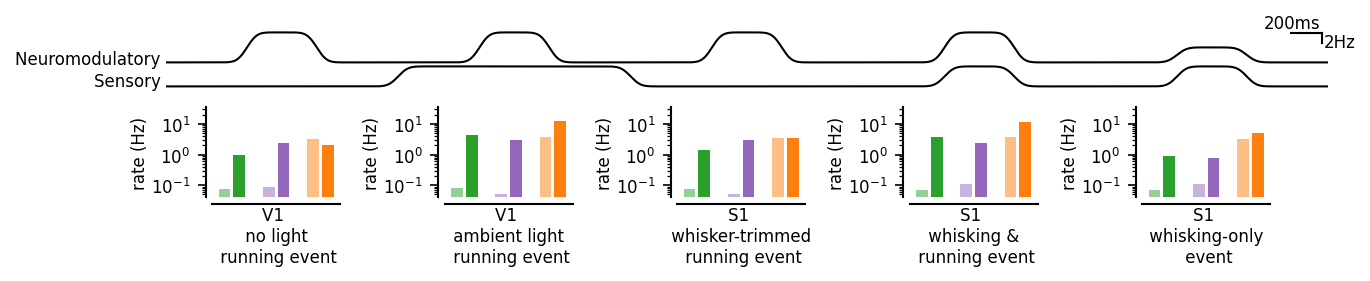

In [7]:
fig, ax = plt.subplots(1, figsize=(10,5))
plt.subplots_adjust(bottom=0.8)

ax.plot(t, Sensory, 'k-')
ax.annotate('Sensory ', (0,0), ha='right')
ax.plot(t, 1.2*Sensory.max()+Neuromodulatory, 'k-')
ax.annotate('Neuromodulatory ', (0,1.1*Sensory.max()), ha='right')
pt.draw_bar_scales(ax, loc='top-right',
                   Xbar=200, Xbar_label='200ms', Ybar=2, Ybar_label='2Hz')
pt.set_plot(ax, [], xticks=[], xlim=[t[0], t[-1]])

INSETS = []
colors =  ['tab:green', 'tab:purple', 'tab:orange']

for e, event in enumerate(Events):
    X0, W0 = (e+.2)/len(Events), .55/len(Events)
    INSETS.append(pt.inset(ax, [X0, -1.8, W0, 1.5,]))
    for p, pop in enumerate(['RecExc', 'VipInh', 'SstInh']):
        for k, key in enumerate(['pre','post']):
            INSETS[e].bar([3*p+k], [RESP[e][pop][key]+5e-2],
                          alpha=0.5*(1+k), color=colors[p])    
    pt.annotate(INSETS[e], event['name'], (0.5, -.1),
                ha='center', va='top')
for i, inset in enumerate(INSETS):
    pt.set_plot(inset, xticks=[], ylim=[4e-2, 35], yscale='log', ylabel='rate (Hz)')    

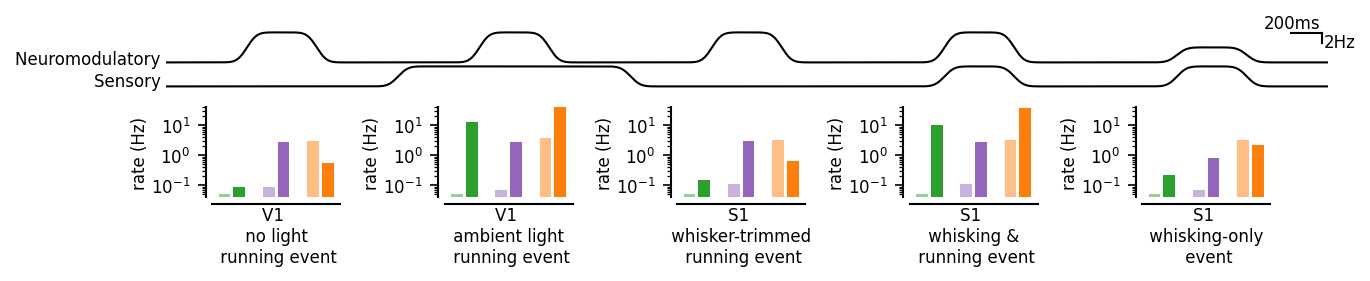

In [83]:
fig, ax = plt.subplots(1, figsize=(10,5))
plt.subplots_adjust(bottom=0.8)

ax.plot(t, Sensory, 'k-')
ax.annotate('Sensory ', (0,0), ha='right')
ax.plot(t, 1.2*Sensory.max()+Neuromodulatory, 'k-')
ax.annotate('Neuromodulatory ', (0,1.1*Sensory.max()), ha='right')
pt.draw_bar_scales(ax, loc='top-right',
                   Xbar=200, Xbar_label='200ms', Ybar=2, Ybar_label='2Hz')
pt.set_plot(ax, [], xticks=[], xlim=[t[0], t[-1]])

INSETS = []
colors =  ['tab:green', 'tab:purple', 'tab:orange']

for e, event in enumerate(Events):
    X0, W0 = (e+.2)/len(Events), .55/len(Events)
    INSETS.append(pt.inset(ax, [X0, -1.8, W0, 1.5,]))
    for p, pop in enumerate(['RecExc', 'VipInh', 'SstInh']):
        for k, key in enumerate(['pre','post']):
            INSETS[e].bar([3*p+k], [RESP[e][pop][key]+5e-2],
                          alpha=0.5*(1+k), color=colors[p])    
    pt.annotate(INSETS[e], event['name'], (0.5, -.1),
                ha='center', va='top')
for i, inset in enumerate(INSETS):
    pt.set_plot(inset, xticks=[], ylim=[4e-2, 40], yscale='log', ylabel='rate (Hz)')    